# Importando dados

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
def matriz_confusao(y_test, y_pred):
    matriz = confusion_matrix(y_test, y_pred)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))
    fig.suptitle('Matriz de Confusão', y=1.1)
    # criando mapa de calor com valores absolutos
    sns.heatmap(matriz, annot=True, fmt='d', cmap='Blues', ax=ax1)
    ax1.set_xlabel('Valores Preditos')
    ax1.set_ylabel('Valores Observados')

    # criando mapa de calor com valores relativos
    sns.heatmap(matriz / np.sum(matriz), annot=True, fmt='.2%', cmap='Blues', ax=ax2)
    ax2.set_xlabel('Valores Preditos')
    ax2.set_ylabel('Valores Observados')

    fig.tight_layout()

In [3]:
def curva_ROC(y_test, y_pred, model):
    logit_roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
    plt.figure(figsize=(4,2))
    plt.plot(fpr, tpr, label=f'Regressão Logística (área = {round(logit_roc_auc, 2)})')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlabel('Taxa de Falso Positivo')
    plt.ylabel('Taxa de Verdadeiro Positivo')
    plt.title('Curva ROC')
    plt.legend(loc="lower right");

In [4]:
dados = pd.read_csv('dados.csv')
dados.head()

,NU_IDADE_N,EVOLUCAO,CS_SEXO_1,CS_RACA_1,CS_RACA_2,CS_RACA_3,CS_ESCOL_N_1,CS_ESCOL_N_3,CS_ESCOL_N_4,NOSOCOMIAL_1,...,UTI_1,SUPORT_VEN_1,DOR_ABD_1,PERD_OLFT_1,PERD_PALA_1,VACINA_COV_1,REGIAO_0,REGIAO_1,REGIAO_2,REGIAO_4
0,75,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,1,0,0,0
1,101,1,1,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0
2,82,0,1,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,94,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,38,0,0,0,0,0,0,1,0,0,...,0,0,0,1,1,1,0,1,0,0


# Classificação


In [5]:
X = dados.drop('EVOLUCAO', axis=1)
y = dados['EVOLUCAO']

In [6]:
y.value_counts()

0    37113
1    19903
Name: EVOLUCAO, dtype: int64

A variável `EVOLUCAO` está desbalanceda, portanto vamos usar Undersampling.

In [7]:
undersample = RandomUnderSampler(sampling_strategy='majority')
X, y = undersample.fit_resample(X, y)

In [8]:
colunas = X.columns
print(dados.shape)
print(X.shape)

(57016, 41)
(39806, 40)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3, stratify=y)

A variável `NU_IDADE_N` é a única que não é binária, portanto vamos aplicar uma transformação MinMax nesta variável.

In [10]:
scaler = MinMaxScaler()
X_train['NU_IDADE_N'] = scaler.fit_transform(X_train['NU_IDADE_N'].values.reshape(-1,1))
X_test['NU_IDADE_N'] = scaler.transform(X_test['NU_IDADE_N'].values.reshape(-1,1))

## Regressão Logística - sklearn

In [11]:
clf1 = LogisticRegression(class_weight='balanced', random_state=42)

In [12]:
parameters_logReg = {'penalty': ['l1', 'l2','elasticnet',None],
                    'C': [0.001, 0.01, 0.1, 1, 10],
                    'solver': ['lbfgs','liblinear','newton-cg'],
                  }

grid_clf1 = RandomizedSearchCV(clf1, parameters_logReg, random_state=42,
                                  cv=5, verbose=2, n_jobs=-1).fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [13]:
print(f'RandomizedSearchCV Best Params: {grid_clf1.best_params_}')

RandomizedSearchCV Best Params: {'solver': 'lbfgs', 'penalty': None, 'C': 1}


In [14]:
grid_clf1 = grid_clf1.best_estimator_
grid_clf1.get_params()

{'C': 1,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': None,
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [15]:
print(grid_clf1.intercept_)

[-2.15290028]


In [16]:
# get importance
importance = grid_clf1.coef_[0]

# summarize feature importance
for coluna,imp in zip(colunas, importance):
    print(f'Variável: {coluna}, Importância: {imp}')

Variável: NU_IDADE_N, Importância: 3.3606368064737415
Variável: CS_SEXO_1, Importância: -0.19072224972749818
Variável: CS_RACA_1, Importância: 0.18512751353736914
Variável: CS_RACA_2, Importância: 0.16094692057931737
Variável: CS_RACA_3, Importância: 0.751713593368169
Variável: CS_ESCOL_N_1, Importância: -0.03487649628705168
Variável: CS_ESCOL_N_3, Importância: -0.11804135399308885
Variável: CS_ESCOL_N_4, Importância: -0.3422226623913058
Variável: NOSOCOMIAL_1, Importância: 0.29041414671217314
Variável: FEBRE_1, Importância: -0.0883404781462091
Variável: TOSSE_1, Importância: -0.49127787411815604
Variável: GARGANTA_1, Importância: -0.401731718367818
Variável: DISPNEIA_1, Importância: 0.35150195639691995
Variável: DESC_RESP_1, Importância: 0.2400307198473946
Variável: SATURACAO_1, Importância: 0.3012926972588988
Variável: DIARREIA_1, Importância: -0.038504445155613964
Variável: VOMITO_1, Importância: -0.020495687940562904
Variável: OUTRO_SIN_1, Importância: -0.2419219352283662
Variável:

In [17]:
y_pred1 = grid_clf1.predict(X_test)
print(classification_report(y_test, y_pred1, zero_division=0))

              precision    recall  f1-score   support

           0       0.72      0.77      0.74      5971
           1       0.75      0.70      0.72      5971

    accuracy                           0.73     11942
   macro avg       0.73      0.73      0.73     11942
weighted avg       0.73      0.73      0.73     11942



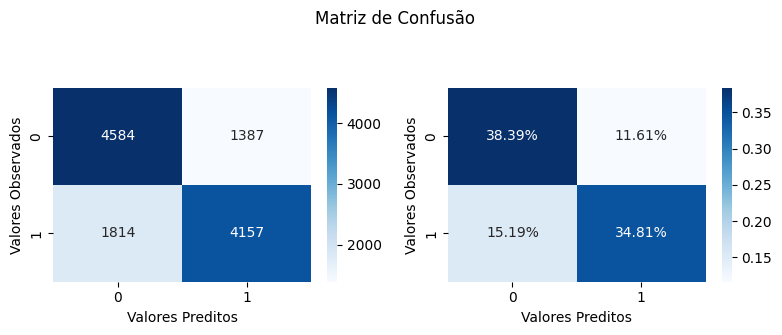

In [18]:
matriz_confusao(y_test, y_pred1)

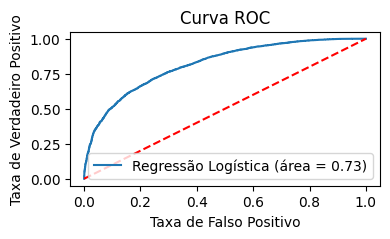

In [19]:
curva_ROC(y_test, y_pred1, grid_clf1)

In [20]:
print(f'Acurácia = {round(accuracy_score(y_test, y_pred1), 2)}')
print(f'Recall = {round(recall_score(y_test, y_pred1), 2)}')
print(f'Precision = {round(precision_score(y_test, y_pred1), 2)}')
print(f'f1_score = {round(f1_score(y_test, y_pred1), 2)}')

Acurácia = 0.73
Recall = 0.7
Precision = 0.75
f1_score = 0.72


## Random Forest

In [21]:
clf2 = RandomForestClassifier(class_weight='balanced', random_state=42)

In [22]:
parameters_clf2 = {'n_estimators':[10,100,150,300,500],
                   'criterion':['gini','entropy','log_loss'],
                   'max_depth':[None,5,10,25,50,100],
                   'max_features':['sqrt','log2',None]}

grid_clf2 = RandomizedSearchCV(clf2, parameters_clf2, cv=5, verbose=1,
                           n_jobs=-1, random_state=42).fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [23]:
print(f'RandomizedSearchCV Best Params: {grid_clf2.best_params_}')

RandomizedSearchCV Best Params: {'n_estimators': 150, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'entropy'}


In [24]:
grid_clf2 = grid_clf2.best_estimator_
grid_clf2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'log2',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 150,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [25]:
y_pred2 = grid_clf2.predict(X_test)
print(classification_report(y_test, y_pred2, zero_division=0))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75      5971
           1       0.76      0.70      0.73      5971

    accuracy                           0.74     11942
   macro avg       0.74      0.74      0.74     11942
weighted avg       0.74      0.74      0.74     11942



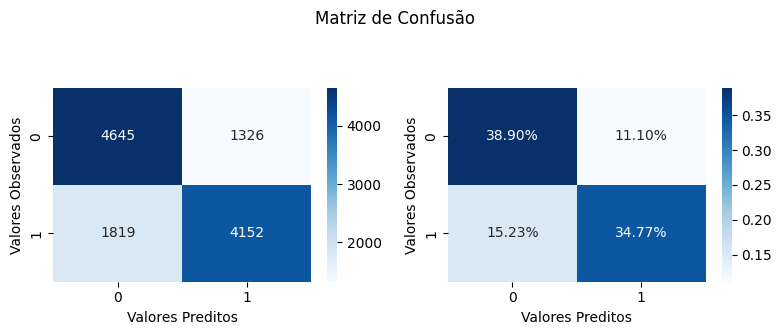

In [26]:
matriz_confusao(y_test, y_pred2)

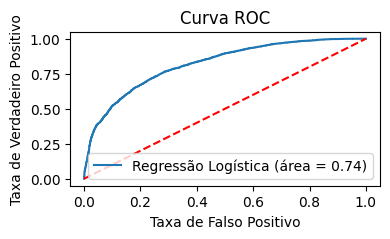

In [27]:
curva_ROC(y_test, y_pred2, grid_clf2)

In [28]:
print(f'Acurácia = {round(accuracy_score(y_test, y_pred2), 2)}')
print(f'Recall = {round(recall_score(y_test, y_pred2), 2)}')
print(f'Precision = {round(precision_score(y_test, y_pred2), 2)}')
print(f'f1_score = {round(f1_score(y_test, y_pred2), 2)}')

Acurácia = 0.74
Recall = 0.7
Precision = 0.76
f1_score = 0.73


# Catboost

In [29]:
!pip install catboost -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.7 MB/s eta 0:00:00


In [30]:
from catboost import CatBoostClassifier

In [31]:
# features categóricas
cat_features = list(range(1, X_train.shape[1]))


embedding_features=[0, 1]

# Initialize CatBoostClassifier
clf3 = CatBoostClassifier(iterations=5,
                           learning_rate=0.1,
                           depth=10,
                           custom_loss=['Accuracy'],
                           random_state=42,
                           loss_function='Logloss',
                           eval_metric='Accuracy')

In [32]:
grid = {'learning_rate': [1, 0.1, 0.01],
'depth': [4, 6, 10, 15, 20],
'l2_leaf_reg': [3, 5],
'iterations': [5, 20, 40]}

In [33]:
clf3.grid_search(grid, X_train, y_train)

0:	learn: 0.6962003	test: 0.6877804	best: 0.6877804 (0)	total: 54.1ms	remaining: 216ms
1:	learn: 0.7162532	test: 0.7071595	best: 0.7071595 (1)	total: 60.5ms	remaining: 90.7ms
2:	learn: 0.7239693	test: 0.7089539	best: 0.7089539 (2)	total: 67.2ms	remaining: 44.8ms
3:	learn: 0.7301602	test: 0.7179257	best: 0.7179257 (3)	total: 74ms	remaining: 18.5ms
4:	learn: 0.7311920	test: 0.7209761	best: 0.7209761 (4)	total: 79.9ms	remaining: 0us

bestTest = 0.7209761349
bestIteration = 4

0:	loss: 0.7209761	best: 0.7209761 (0)	total: 139ms	remaining: 12.4s
0:	learn: 0.6962003	test: 0.6877804	best: 0.6877804 (0)	total: 7ms	remaining: 28ms
1:	learn: 0.7086717	test: 0.7012381	best: 0.7012381 (1)	total: 13.1ms	remaining: 19.6ms
2:	learn: 0.7075501	test: 0.7012381	best: 0.7012381 (1)	total: 19.1ms	remaining: 12.7ms
3:	learn: 0.7079987	test: 0.7021353	best: 0.7021353 (3)	total: 25.4ms	remaining: 6.36ms
4:	learn: 0.7074604	test: 0.6998026	best: 0.7021353 (3)	total: 31.4ms	remaining: 0us

bestTest = 0.7021352

{'params': {'depth': 4,
  'learning_rate': 1,
  'l2_leaf_reg': 5,
  'iterations': 20},
 'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19],
              'test-Accuracy-mean': [0.69229112833764,
               0.7080462245190927,
               0.7164800459374102,
               0.7221145564168819,
               0.7246985357450474,
               0.7276055124892334,
               0.7272825150732128,
               0.7300100488084985,
               0.7304766006316393,
               0.7313020384725811,
               0.7318403674992823,
               0.7337424633936261,
               0.7332400229687052,
               0.735

In [34]:
clf3.get_params()

{'iterations': 20,
 'learning_rate': 1,
 'depth': 4,
 'loss_function': 'Logloss',
 'custom_loss': ['Accuracy'],
 'eval_metric': 'Accuracy',
 'random_state': 42,
 'l2_leaf_reg': 5}

In [35]:
# Fit model
clf3.fit(X_train, y_train, cat_features=cat_features)
y_pred3 = clf3.predict(X_test)

0:	learn: 0.6952699	total: 7.04ms	remaining: 134ms
1:	learn: 0.7156905	total: 14.4ms	remaining: 129ms
2:	learn: 0.7233707	total: 21.4ms	remaining: 121ms
3:	learn: 0.7228682	total: 28ms	remaining: 112ms
4:	learn: 0.7250215	total: 34.9ms	remaining: 105ms
5:	learn: 0.7289334	total: 41.7ms	remaining: 97.3ms
6:	learn: 0.7316968	total: 48.7ms	remaining: 90.4ms
7:	learn: 0.7337425	total: 55ms	remaining: 82.5ms
8:	learn: 0.7341731	total: 61.4ms	remaining: 75.1ms
9:	learn: 0.7347473	total: 67.6ms	remaining: 67.6ms
10:	learn: 0.7356446	total: 74ms	remaining: 60.5ms
11:	learn: 0.7378697	total: 80.8ms	remaining: 53.9ms
12:	learn: 0.7383721	total: 87.3ms	remaining: 47ms
13:	learn: 0.7394846	total: 94.2ms	remaining: 40.4ms
14:	learn: 0.7403101	total: 101ms	remaining: 33.7ms
15:	learn: 0.7400947	total: 108ms	remaining: 26.9ms
16:	learn: 0.7407766	total: 116ms	remaining: 20.4ms
17:	learn: 0.7413150	total: 122ms	remaining: 13.6ms
18:	learn: 0.7416021	total: 129ms	remaining: 6.8ms
19:	learn: 0.7425352	t

In [36]:
print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.73      0.76      0.74      5971
           1       0.75      0.72      0.73      5971

    accuracy                           0.74     11942
   macro avg       0.74      0.74      0.74     11942
weighted avg       0.74      0.74      0.74     11942



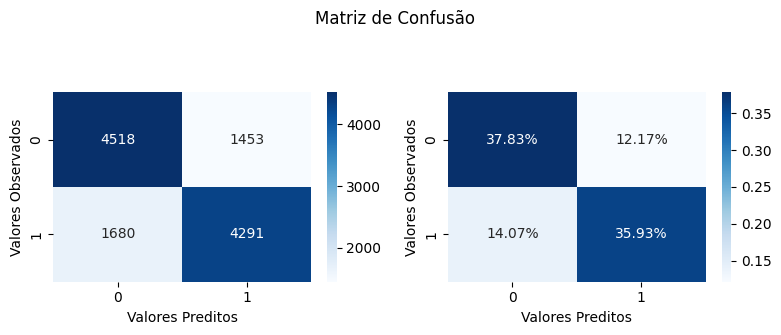

In [37]:
matriz_confusao(y_test, y_pred3)

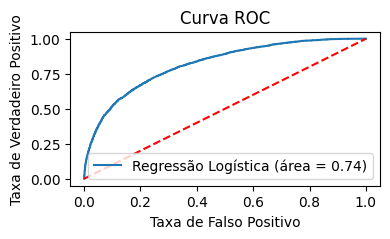

In [38]:
curva_ROC(y_test, y_pred3, clf3)

In [39]:
print(f'Acurácia = {round(accuracy_score(y_test, y_pred3), 2)}')
print(f'Recall = {round(recall_score(y_test, y_pred3), 2)}')
print(f'Precision = {round(precision_score(y_test, y_pred3), 2)}')
print(f'f1_score = {round(f1_score(y_test, y_pred3), 2)}')

Acurácia = 0.74
Recall = 0.72
Precision = 0.75
f1_score = 0.73


In [40]:
print(clf3.get_best_score())

{'learn': {'Accuracy': 0.7425351708297445, 'Logloss': 0.5072550545053073}}


In [41]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

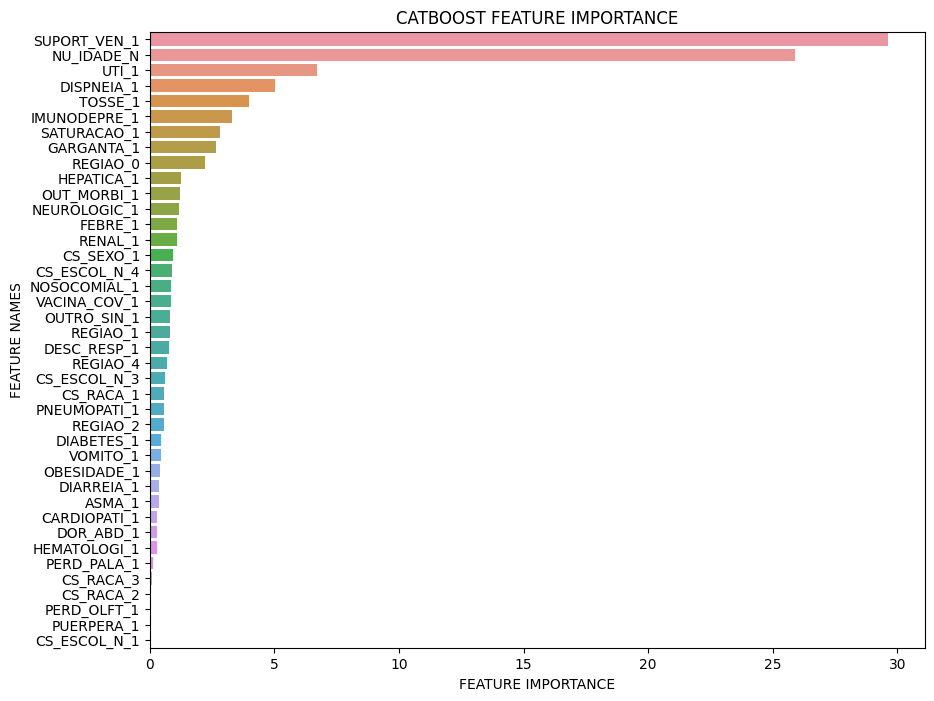

In [42]:
plot_feature_importance(clf3.get_feature_importance(), X_train.columns,'CATBOOST')

# Rede Neural

In [43]:
# instalando bibliotecas
!pip install optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.4/225.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 8.2 MB/s eta 0:00:00


In [44]:
# importando layers
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.metrics import PrecisionAtRecall, Recall
from keras.callbacks import EarlyStopping
import optuna

In [45]:
# funcao para acompanhar a acuracia
def plot_accuracy(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left');

In [46]:
# funcao para acompanhar a função de perda
def plot_loss(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

In [47]:
# Definir a função objetivo para otimização
def objective(trial):
    # Definir os hiperparâmetros a serem otimizados
    hidden_units = trial.suggest_int('hidden_units', 2, 50)
    optimizer = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    epochs = trial.suggest_int('epochs', 20, 50)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.9)

    # Construir o modelo da rede neural
    model = Sequential()
    model.add(Dense(hidden_units, input_dim=40, activation='relu'))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    # Treinar o modelo
    model.fit(X_train, y_train, epochs=epochs, verbose=0)

    # Fazer previsões nos dados de teste
    y_pred = (model.predict(X_test) >= 0.5).astype(int)

    # Calcular o f1-score
    acc = accuracy_score(y_test, y_pred)

    return acc

In [48]:
# Criar um estudo Optuna e otimizar os hiperparâmetros
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# Imprimir os resultados
print(f"Melhores Hiperparâmetros: {study.best_trial.params}")

[I 2023-08-30 00:39:09,347] A new study created in memory with name: no-name-27158a72-e159-4fde-9766-1883245061b1


374/374 [==============================] - 1s 2ms/step


[I 2023-08-30 00:40:35,491] Trial 0 finished with value: 0.732373136828002 and parameters: {'hidden_units': 36, 'optimizer': 'adam', 'epochs': 30, 'dropout_rate': 0.1867135338026266}. Best is trial 0 with value: 0.732373136828002.


374/374 [==============================] - 1s 1ms/step


[I 2023-08-30 00:41:33,534] Trial 1 finished with value: 0.7245017584994138 and parameters: {'hidden_units': 6, 'optimizer': 'adam', 'epochs': 38, 'dropout_rate': 0.6182723374419536}. Best is trial 0 with value: 0.732373136828002.


374/374 [==============================] - 1s 2ms/step


[I 2023-08-30 00:42:22,511] Trial 2 finished with value: 0.7295260425389382 and parameters: {'hidden_units': 31, 'optimizer': 'rmsprop', 'epochs': 34, 'dropout_rate': 0.1420933604184235}. Best is trial 0 with value: 0.732373136828002.


374/374 [==============================] - 1s 1ms/step


[I 2023-08-30 00:43:21,661] Trial 3 finished with value: 0.734634064645788 and parameters: {'hidden_units': 32, 'optimizer': 'rmsprop', 'epochs': 42, 'dropout_rate': 0.6554780582462623}. Best is trial 3 with value: 0.734634064645788.


374/374 [==============================] - 1s 1ms/step


[I 2023-08-30 00:44:04,255] Trial 4 finished with value: 0.71545804722827 and parameters: {'hidden_units': 7, 'optimizer': 'rmsprop', 'epochs': 23, 'dropout_rate': 0.6684915383443479}. Best is trial 3 with value: 0.734634064645788.


374/374 [==============================] - 1s 1ms/step


[I 2023-08-30 00:45:28,088] Trial 5 finished with value: 0.7351364930497404 and parameters: {'hidden_units': 20, 'optimizer': 'rmsprop', 'epochs': 43, 'dropout_rate': 0.20795536268270087}. Best is trial 5 with value: 0.7351364930497404.


374/374 [==============================] - 1s 1ms/step


[I 2023-08-30 00:46:10,931] Trial 6 finished with value: 0.7388209680120583 and parameters: {'hidden_units': 36, 'optimizer': 'adam', 'epochs': 26, 'dropout_rate': 0.8553089218344463}. Best is trial 6 with value: 0.7388209680120583.


374/374 [==============================] - 1s 1ms/step


[I 2023-08-30 00:47:34,496] Trial 7 finished with value: 0.7340478981745101 and parameters: {'hidden_units': 49, 'optimizer': 'rmsprop', 'epochs': 33, 'dropout_rate': 0.5365654344389171}. Best is trial 6 with value: 0.7388209680120583.


374/374 [==============================] - 1s 1ms/step


[I 2023-08-30 00:48:58,791] Trial 8 finished with value: 0.7360576117903199 and parameters: {'hidden_units': 19, 'optimizer': 'adam', 'epochs': 42, 'dropout_rate': 0.5964055502702225}. Best is trial 6 with value: 0.7388209680120583.


374/374 [==============================] - 1s 1ms/step


[I 2023-08-30 00:49:35,880] Trial 9 finished with value: 0.7387372299447329 and parameters: {'hidden_units': 27, 'optimizer': 'rmsprop', 'epochs': 24, 'dropout_rate': 0.485835925242741}. Best is trial 6 with value: 0.7388209680120583.


374/374 [==============================] - 1s 1ms/step


[I 2023-08-30 00:50:53,278] Trial 10 finished with value: 0.7297772567409144 and parameters: {'hidden_units': 44, 'optimizer': 'adam', 'epochs': 50, 'dropout_rate': 0.8815479852988803}. Best is trial 6 with value: 0.7388209680120583.


374/374 [==============================] - 1s 1ms/step


[I 2023-08-30 00:51:36,787] Trial 11 finished with value: 0.7375648970021772 and parameters: {'hidden_units': 24, 'optimizer': 'adam', 'epochs': 20, 'dropout_rate': 0.40968949434089375}. Best is trial 6 with value: 0.7388209680120583.


374/374 [==============================] - 1s 1ms/step


[I 2023-08-30 00:52:15,436] Trial 12 finished with value: 0.7291910902696366 and parameters: {'hidden_units': 39, 'optimizer': 'rmsprop', 'epochs': 26, 'dropout_rate': 0.8874405958433627}. Best is trial 6 with value: 0.7388209680120583.


374/374 [==============================] - 1s 2ms/step


[I 2023-08-30 00:52:56,843] Trial 13 finished with value: 0.7356389214536928 and parameters: {'hidden_units': 27, 'optimizer': 'adam', 'epochs': 27, 'dropout_rate': 0.41895678814812076}. Best is trial 6 with value: 0.7388209680120583.


374/374 [==============================] - 1s 1ms/step


[I 2023-08-30 00:53:39,486] Trial 14 finished with value: 0.7201473789984927 and parameters: {'hidden_units': 13, 'optimizer': 'rmsprop', 'epochs': 21, 'dropout_rate': 0.7685470960694377}. Best is trial 6 with value: 0.7388209680120583.


Melhores Hiperparâmetros: {'hidden_units': 36, 'optimizer': 'adam', 'epochs': 26, 'dropout_rate': 0.8553089218344463}


In [49]:
# treinando a rede neural com os melhores hiperparâmetros
best_params = study.best_trial.params

clf4 = Sequential()
clf4.add(Dense(best_params['hidden_units'], input_dim=40, activation='relu'))
clf4.add(Dense(best_params['hidden_units'], activation='relu'))
clf4.add(Dropout(best_params['dropout_rate']))
clf4.add(Dense(best_params['hidden_units'], activation='relu'))
clf4.add(Dropout(best_params['dropout_rate']))
clf4.add(Dense(1, activation='sigmoid'))
clf4.compile(loss='binary_crossentropy', optimizer=best_params['optimizer'], metrics=['accuracy'])

# callbacks
callback = EarlyStopping(monitor='loss', patience=5, verbose=False)

# Treinar o modelo com todos os dados de treinamento
history = clf4.fit(X_train, y_train,
                   epochs=best_params['epochs'],
                   callbacks=[callback],
                   validation_split = 0.20,
                   verbose=False)

# Fazer previsões com o modelo treinado
y_pred4 = (clf4.predict(X_test) >= 0.5).astype(int)

374/374 [==============================] - 1s 1ms/step


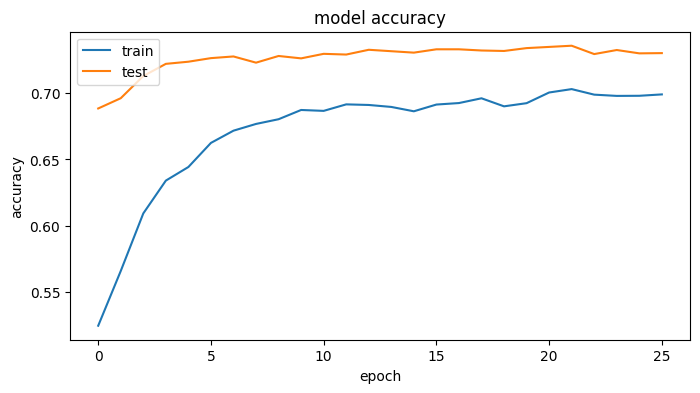

In [50]:
plot_accuracy(history)

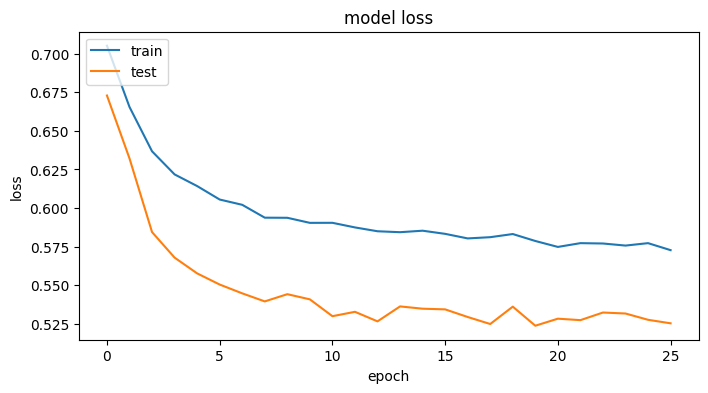

In [51]:
plot_loss(history)

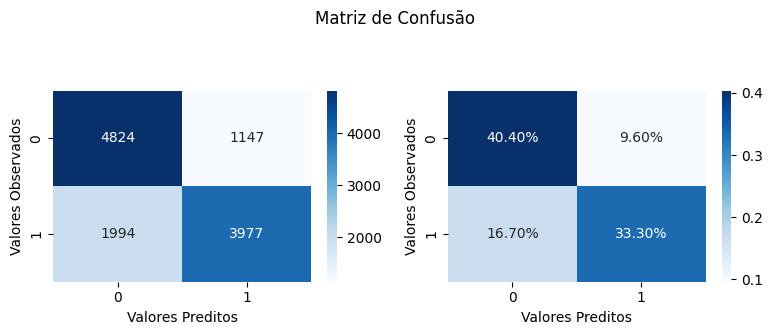

In [52]:
matriz_confusao(y_test, y_pred4)

In [53]:
# observando métricas por classe
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.71      0.81      0.75      5971
           1       0.78      0.67      0.72      5971

    accuracy                           0.74     11942
   macro avg       0.74      0.74      0.74     11942
weighted avg       0.74      0.74      0.74     11942



374/374 [==============================] - 0s 1ms/step


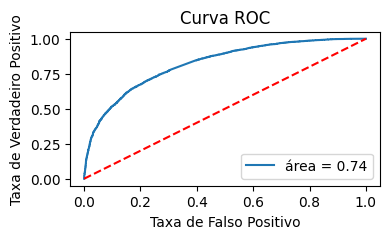

In [54]:
# curva ROC
logit_roc_auc = roc_auc_score(y_test, y_pred4)
fpr, tpr, thresholds = roc_curve(y_test, clf4.predict(X_test))
plt.figure(figsize=(4,2))
plt.plot(fpr, tpr, label=f'área = {round(logit_roc_auc, 2)}')
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc="lower right");

In [55]:
print(f'Acurácia = {round(accuracy_score(y_test, y_pred4), 2)}')
print(f'Recall = {round(recall_score(y_test, y_pred4), 2)}')
print(f'Precision = {round(precision_score(y_test, y_pred4), 2)}')
print(f'f1_score = {round(f1_score(y_test, y_pred4), 2)}')

Acurácia = 0.74
Recall = 0.67
Precision = 0.78
f1_score = 0.72
